# Micrograd

## Import the Libraries

In [2]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Defining Classes and Functions

In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def exp(self): #added
        """Compute the exponential of the Value object."""
        out = Value(np.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad  # Derivative of exp(x) is exp(x)
        out._backward = _backward

        return out

    def log(self): #added
        """Compute the natural logarithm of the Value object."""
        out = Value(np.log(self.data), (self,), 'log')

        def _backward():
            self.grad += (1 / self.data) * out.grad  # Derivative of log(x) is 1/x
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [5]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Backpropagation

In [6]:
# Build a multi-layer-perceptron

x = [2.0, 3.0, -1.0]
n = MLP(3,[4, 4, 1])
n(x)

Value(data=0.05947764903919421, grad=0)

In [7]:
# Define xs, ys, ypred, and loss

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.7850367184098976, grad=0)

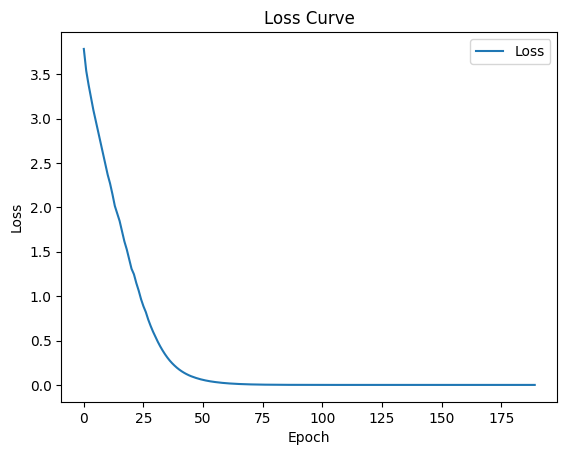

In [8]:
# Initialize lists to store loss values
loss_history = []

# Training loop
for epoch in range(190):  # Adjust the number of epochs as needed
    # Forward pass: compute predictions
    ypred = [n(x) for x in xs]

    # Compute loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss_history.append(loss.data)  # Store the loss value

    # Backward pass: compute gradients
    loss.backward()

    # Update weights
    for p in n.parameters():
        p.data -= 0.01 * p.grad  # Learning rate of 0.01

    # Zero the gradients for the next iteration
    for p in n.parameters():
        p.grad = 0.0

# Plot the loss curve
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## Implementation on Wine Dataset

In [28]:
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
wine = load_wine()

# Features (Xs)
X = wine.data  # Shape: (178, 13)

# Target labels (ys)
y = wine.target  # Shape: (178,)

# Standardize the features
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_scaled = (X - mean) / std

# One-hot encode the targets
num_classes = len(np.unique(y))
y_one_hot = np.zeros((len(y), num_classes))
y_one_hot[np.arange(len(y)), y] = 1

# Shuffle the dataset
np.random.seed(24)
indices = np.arange(len(X))
np.random.shuffle(indices)

# Split into training and testing sets
test_size = 0.2
split_index = int(len(X) * (1 - test_size))
X_train, X_test = X_scaled[indices[:split_index]], X_scaled[indices[split_index:]]
y_train_one_hot, y_test_one_hot = y_one_hot[indices[:split_index]], y_one_hot[indices[split_index:]]

# Convert y_train to Value objects
y_train_one_hot = [[Value(ygt_i) for ygt_i in ygt] for ygt in y_train_one_hot]

In [29]:
# Define the model
model = MLP(13, [26, 26, 3])  # 13 input features, 3 hidden layers with 16 neurons, 3 output classes

In [30]:
# Define softmax function for Value objects
def softmax(logits):
    exp_logits = [logit.exp() for logit in logits]  # Use the exp method
    sum_exp_logits = sum(exp_logits)  # Sum of exp(logits)
    return [exp_logit / sum_exp_logits for exp_logit in exp_logits]  # Softmax probabilities

# Define cross-entropy loss for Value objects
def cross_entropy_loss(probs, true_labels):
    loss = 0
    for p, y in zip(probs, true_labels):
        loss += -p[y].log()  # Negative log likelihood of the true class
    return loss / len(true_labels)  # Average loss

In [31]:
# Training loop
num_epochs = 30
learning_rate = 0.10
decay_rate = 0.5  # Reduce learning rate
decay_epochs = 10  # Reduce learning rate every X epochs
loss_history = []

for epoch in range(num_epochs):
    # Reduce learning rate every `decay_epochs` epochs
    if epoch > 0 and epoch % decay_epochs == 0:
        learning_rate *= decay_rate
        print(f"Reduced learning rate to {learning_rate:.4f} at epoch {epoch + 1}")

    # Forward pass: compute predictions
    ypred = [model(x) for x in X_train] # Forward passing...

    # Apply softmax to convert logits to probabilities
    ypred_probs = [softmax(logits) for logits in ypred]

    # Extract true labels (indices of the maximum value in each one-hot encoded vector)
    true_labels = [np.argmax([ygt_i.data for ygt_i in ygt]) for ygt in y_train_one_hot]

    # Compute cross-entropy loss
    loss = cross_entropy_loss(ypred_probs, true_labels)
    loss_history.append(loss.data)

    # Backward pass: compute gradients
    loss.backward() # Backward passing...

    # Update weights with the current learning rate
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # Zero the gradients for the next iteration
    model.zero_grad()

    # Print loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.data:.3f}, Learning Rate: {learning_rate}")

Epoch 5, Loss: 0.579, Learning Rate: 0.1
Epoch 10, Loss: 0.223, Learning Rate: 0.1
Reduced learning rate to 0.0500 at epoch 11
Epoch 15, Loss: 0.155, Learning Rate: 0.05
Epoch 20, Loss: 0.120, Learning Rate: 0.05
Reduced learning rate to 0.0250 at epoch 21
Epoch 25, Loss: 0.104, Learning Rate: 0.025
Epoch 30, Loss: 0.093, Learning Rate: 0.025
Reduced learning rate to 0.0125 at epoch 31
Epoch 35, Loss: 0.086, Learning Rate: 0.0125
Epoch 40, Loss: 0.081, Learning Rate: 0.0125
Reduced learning rate to 0.0063 at epoch 41
Epoch 45, Loss: 0.079, Learning Rate: 0.00625
Epoch 50, Loss: 0.076, Learning Rate: 0.00625


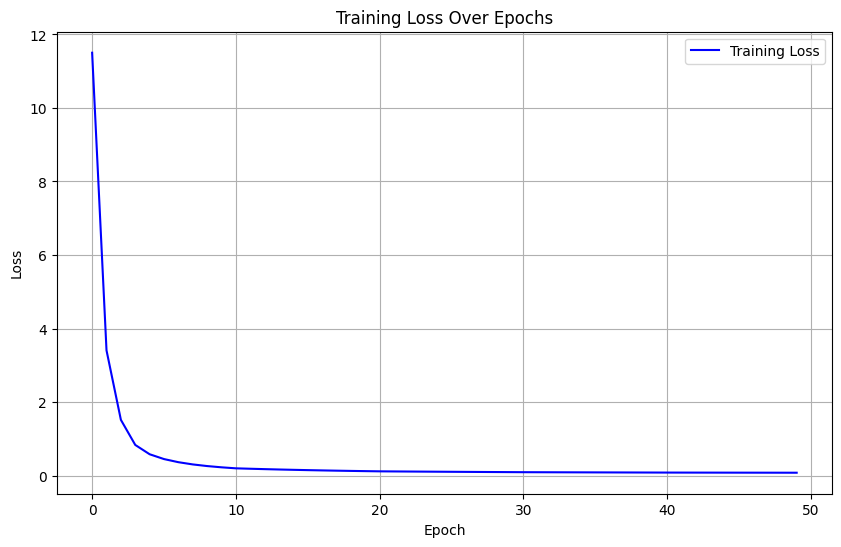

In [32]:
# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluate the model on the test set
ypred_test = [model(x) for x in X_test]
ypred_test_probs = [softmax(logits) for logits in ypred_test]
ypred_test_labels = np.array([np.argmax([p.data for p in probs]) for probs in ypred_test_probs])
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_labels, ypred_test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, ypred_test_labels)
print("Confusion Matrix:")
print(cm)

# Compute classification report
print("Classification Report:")
print(classification_report(y_test_labels, ypred_test_labels, target_names=wine.target_names))

Test Accuracy: 86.11%
Confusion Matrix:
[[ 9  0  0]
 [ 2 11  2]
 [ 0  1 11]]
Classification Report:
              precision    recall  f1-score   support

     class_0       0.82      1.00      0.90         9
     class_1       0.92      0.73      0.81        15
     class_2       0.85      0.92      0.88        12

    accuracy                           0.86        36
   macro avg       0.86      0.88      0.86        36
weighted avg       0.87      0.86      0.86        36



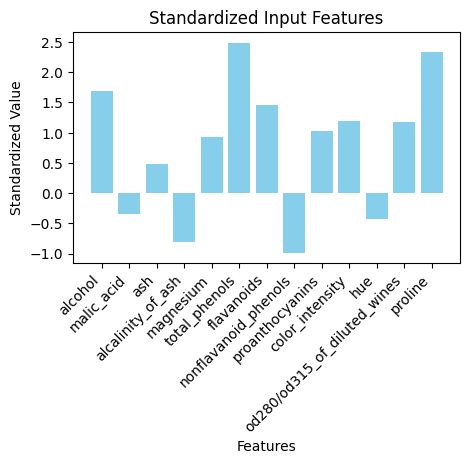

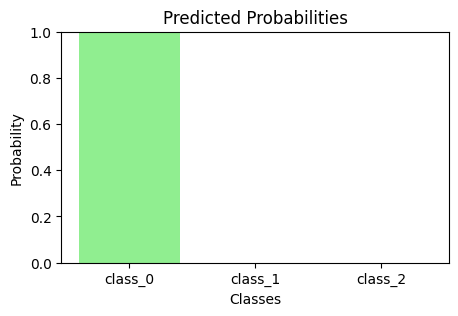

Actual class Label: 0


In [50]:
# Extract feature names
feature_names = wine.feature_names

# Function to visualize standardized input features
def visualize_input_features(sample, feature_names):
    plt.figure(figsize=(5, 3))
    plt.bar(feature_names, sample, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Standardized Value')
    plt.title('Standardized Input Features')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Function to visualize predicted probabilities
def visualize_predicted_probabilities(probs, class_names):
    plt.figure(figsize=(5, 3))
    plt.bar(class_names, probs, color='lightgreen')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title('Predicted Probabilities')
    plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for probabilities
    plt.show()

# Select a sample from the test set
sample_index = 0  # Change this to visualize a different sample
sample = X_test[sample_index]

# Visualize standardized input features
visualize_input_features(sample, feature_names)

# Make a prediction for the selected sample
ypred_sample = model(sample)  # Get raw logits
ypred_probs = softmax(ypred_sample)  # Apply softmax to get probabilities

# Extract probabilities as a list of floats
probs = [p.data for p in ypred_probs]  # Fixed: Added the missing closing bracket

# Visualize predicted probabilities
visualize_predicted_probabilities(probs, wine.target_names)

print(f"Actual class Label: {y_test_labels[sample_index]}")